In [73]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import transformers
from transformers import pipeline
from transformers import PreTrainedTokenizerFast
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re
from collections import defaultdict
import comprehension_model
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import pearsonr,spearmanr

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def get_most_frequent_tokens(valid_dataset, top_n=1000):
    token_counts = defaultdict(int)

    for example in valid_dataset: 
        labels = example['labels']
        for label in labels:
            if label != -100:
                token_counts[label] += 1
    
    
    return token_counts

# Example usage
# # Assuming valid_dataset and tokenizer are already loaded
# most_frequent_tokens = get_most_frequent_tokens(valid_dataset)

def special_token(token,example):
    return token in example['labels']

def filter_and_process_dataset(valid_dataset, valid_token_list, tokenizer, preprocessing, max_examples=10000, max_filtered=1000):
    filtered_datasets = {}

    for token_id in most_frequent_tokens:
        # Filter the dataset for the current token
        valid_filtered_dataset = valid_dataset.select(range(max_examples)).filter(lambda example: special_token(token_id, example))
        
        # Skip if the filtered dataset is empty
        if len(valid_filtered_dataset) == 0:
            continue
        
        # Process the filtered dataset with the context mask
        valid_sentence_filtered = valid_filtered_dataset.map(lambda example: preprocessing.get_context_with_mask(example, token_id, tokenizer))
        
        # Limit to max_filtered examples for efficiency
        limited_dataset = valid_sentence_filtered.select(range(min(len(valid_sentence_filtered), max_filtered)))
        
        filtered_datasets[token_id] =limited_dataset
        print(f"Processed token ID: {token_id} with {len(limited_dataset)} examples")

    return filtered_datasets


# filtered_datasets = filter_and_process_dataset(valid_dataset,valid_tokens_list,tokenizer,preprocessing)
# with open("word_embedding_distance_layer12.csv","w") as file :
#     writer=csv.writer(file)
#     writer.writerow(["indices", "token","euclidean_distances","cosine similarity" ])




In [49]:
def get_embedding_norms(model):
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()
    embeddings_norm =model.bert.embeddings.LayerNorm(embeddings)
    norms = torch.norm(embeddings_norm, dim=1)
    return norms

In [57]:

def get_embedding_normalized(model):
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()
    embeddings_norm =model.bert.embeddings.LayerNorm(embeddings)
    return embeddings_norm

In [55]:
def unique_token_ids(dataset):
    unique_token_ids = set()
    for example in dataset:
        unique_token_ids.update(example['input_ids'])
    return torch.tensor(sorted(unique_token_ids))

def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()

In [75]:
def special_token(token,example):
    return token in example['labels']


In [6]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

Models used

In [8]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [9]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [11]:
exbert_tokenizer=AutoTokenizer.from_pretrained("exbert_tokenizer")
model_exbert = AutoModelForMaskedLM.from_pretrained("exbert-finetuned-imdb/checkpoint-5327520")
model_exbert=model_exbert.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [71]:

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/pretraining_scratch/checkpoint-5258900/tokenizer.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]")
    
    
config = transformers.BertConfig.from_pretrained("/home/laurinemeier/swerick/pretraining_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("/home/laurinemeier/swerick/pretraining_scratch/checkpoint-5258900",config=config,trust_remote_code=True)
mosaicBert.to(device)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-5258900/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50328, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out

Entire dataset

In [21]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)

batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


Map:   0%|          | 0/764056 [00:00<?, ? examples/s]

ok


Small dataset

In [ ]:
from datasets import Dataset
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
small_valid_dataset = preprocessing.create_deterministic_eval_dataset(valid_dataset.select(range(10000)),data_collator)
small_valid_dataloader=preprocessing.create_dataloader(small_valid_dataset,64,default_data_collator)

Filtered Dataset

In [ ]:
word = "Statsrådet"
token_id = tokenizer.convert_tokens_to_ids(word)
valid_filtered_dataset = valid_dataset.select(range(100000)).filter(lambda example : special_token(token_id,example))
valid_filtered_dataloader=preprocessing.create_dataloader(valid_filtered_dataset,64,default_data_collator)

Propagation effect

In [ ]:
            
import numpy as np

gamma_1 = model_kb.bert.encoder.layer[8].intermediate.dense.weight.detach().cpu().numpy()
index=4

input_ids = torch.tensor(valid_dataset[-10]["input_ids"], dtype=torch.long).unsqueeze(0).to(device)
attention_mask = torch.tensor(valid_dataset[-10]["attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
labels = torch.tensor(valid_dataset[-10]["labels"], dtype=torch.long).unsqueeze(0).to(device)

# Obtenez les sorties des modèles
output = model_kb(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)
hidden_state = output.hidden_states[0].detach()
#hidden_state = hidden_states[index].detach()
Attention = model_kb.bert.encoder.layer[3].attention
First_layer = model_kb.bert.encoder.layer[3].intermediate.dense
X = Attention(hidden_state)[0]
X_first_layer = First_layer(X)
GELU_derivative = 0.5 * (1 + torch.tanh(np.sqrt(2 / torch.pi) * (X_first_layer + 0.044715 * X_first_layer**3)) + X_first_layer* (1-torch.tanh(np.sqrt(2 / torch.pi) * (X_first_layer + 0.044715 * X_first_layer**3))**2) * (np.sqrt(2 / torch.pi) * (1 + 0.044715 * X_first_layer**2)))

print (GELU_derivative.size())                                                                                                                                                                                           
GELU_derivative = GELU_derivative.reshape(128,-1).detach().cpu().numpy()
print (GELU_derivative)  
#Q = model_kb.bert.encoder.layer[index].attention.self.query(hidden_state)
#K = model_kb.bert.encoder.layer[index].attention.self.key(hidden_state)
d=769
#scores = torch.matmul(Q,K.transpose(-2,-1))/np.sqrt(d)

# jacobians = []

# # Calculer la jacobienne pour chaque ligne
# for i in range(scores.size(1)):
#     s = scores[0,i]
#     jacobian =jacobian_softmax(s)
#     jacobians.append(jacobian)
        

norm_2 = np.linalg.norm(GELU_derivative, 2)
print(norm_2)

Cosine Similarity Word Embedding

In [18]:
# Frequent words  in training corpus

most_frequent_tokens = get_most_frequent_tokens(lm_datasets["train"])

KeyboardInterrupt: 

In [ ]:
token_sim = {}

with open('cosine_similarity_words_emebdding_cpt.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            key, value = line.split(': ')
            token_sim[key]=float(value)
    
    

In [20]:
# Token frequency in the training corpus
# 
token_frequency_dict = {}
with open("token_frequency.txt",'r') as f:
    for line in f:
        line = line.strip()
        if line:
            if line[0]==':':
                token,frequency = ':',line[3:]
            else :
                token, frequency = line.split(':')
                
            token = token.strip()
            frequency = int(frequency.strip())
            token_frequency_dict[token] = frequency

In [ ]:
#Correaltion between frequency and cosine similarity in word embedding 
from scipy.stats import spearmanr, pearsonr

#frequency_dict = {word: count for word, count in most_frequent_words}
ids_in_corpus=[tokenizer.convert_tokens_to_ids(token) for token in list(token_frequency_dict.keys())]
print(ids_in_corpus)
token_norm = [exbert_norms[index] for index in ids_in_corpus]


pearson_corr, _ = pearsonr(list(token_frequency_dict.values()),token_norm)
print(f'Corrélation de Pearson : {pearson_corr}')

# Calculer la corrélation de Spearman
spearman_corr, _ = spearmanr(list(token_frequency_dict.values()),token_norm)
print(f'Corrélation de Spearman : {spearman_corr}')

# Combine frequencies and cosine similarities
frequency_similarity_pairs = [(freq, norm) for freq, norm in zip(list(token_frequency_dict.values()),token_norm)]
freqs, sims = zip(*frequency_similarity_pairs)

# Calculate Pearson correlation
pearson_corr, p_value = pearsonr(freqs, sims)
print(f"Pearson correlation: {pearson_corr}, P-value: {p_value}")
spearman_corr, p_value = spearmanr(freqs, sims)
print(f"Spearman correlation: {spearman_corr}, P-value: {p_value}")

plt.scatter(sims,freqs, alpha=0.5)
plt.title('Token Frequency vs. Norm Embedding')
plt.xlabel('Norm embedding')
plt.ylabel('Frequency')
plt.show()
import pandas as pd

# Create a DataFrame for easier manipulation
df = pd.DataFrame(frequency_similarity_pairs, columns=['Frequency', 'norm_embedding'])

# Bin the frequencies
df['Frequency Bin'] = pd.qcut(df['norm_embedding'], q=10, duplicates='drop')

# Plot box plot
plt.figure(figsize=(12, 6))
df.boxplot(column='Frequency', by='Frequency Bin', grid=False, showfliers=False)
plt.title(' Frequency Bin by Norm Embedding')
plt.suptitle('')
plt.xlabel('Norm Bin')
plt.xticks(rotation=45)  
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np

frequency_last_100 = [frequency_dict[word] for word in token_sim[-100:]]
print("mean frequency last 100",np.mean(frequency_last_100))

frequency_first_100 = [frequency_dict[word] for word in token_sim[:100]]
print("mean frequency first 100",np.mean(frequency_first_100))




# Perform t-test
t_stat, p_value = ttest_ind(frequency_last_100, frequency_first_100, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference in frequencies is statistically significant.")
else:
    print("The difference in frequencies is not statistically significant.")
    
    

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(frequency_last_100, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Frequency Distribution - Last 100 Tokens')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(frequency_first_100, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Frequency Distribution - First 100 Tokens')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(8, 6))
plt.boxplot([frequency_last_100, frequency_first_100], labels=['Last 100 Tokens', 'First 100 Tokens'])
plt.title('Frequency Box Plot')
plt.ylabel('Frequency')
plt.show()


def print_statistics(data, label):
    print(f"Statistics for {label}:")
    print(f"  Mean: {np.mean(data)}")
    print(f"  Median: {np.median(data)}")
    print(f"  Mode: {max(set(data), key=data.count)}")
    print(f"  Standard Deviation: {np.std(data)}")
    print(f"  Min: {np.min(data)}")
    print(f"  Max: {np.max(data)}")
    print()

print_statistics(frequency_last_100, "Last 100 Tokens")
print_statistics(frequency_first_100, "First 100 Tokens")

In [ ]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
euclidean_measures =[]
cosine_measures = []
tokens=[]
for token in filtered_datasets.keys() :
    valid_sentence_filtered = filtered_datasets[token]
    dataloader  =preprocessing.create_dataloader(valid_sentence_filtered,1,default_data_collator)
    baseline_embeddings = comprehension_model.get_embeddings(model_kb, dataloader, tokenizer)
    finetuned_embeddings = comprehension_model.get_embeddings(model_hugging_face, dataloader, tokenizer)
    euclidean_distances = [euclidean(baseline, finetuned) for baseline, finetuned in zip(baseline_embeddings[-1], finetuned_embeddings[-1])]
    euclidean_measures.append(np.mean(euclidean_distances))
    cosine_measure = cosine_similarity(baseline_embeddings[-1], finetuned_embeddings[-1])
    avg_cosine = np.mean(cosine_measure)
    cosine_measures.append(avg_cosine)
    tokens.append(token)
    with open("word_embedding_distance_layer12.csv", "a") as file:
        writer = csv.writer(file)
        writer.writerow([i, token,np.mean(euclidean_distances),avg_cosine ])
    print(tokenizer.decode(token))
    
high_separated_indices12 = sorted(range(len(euclidean_measures)), key=lambda i: euclidean_measures[i], reverse=True)[:50]
least_separated_indices12 = sorted(range(len(euclidean_measures)), key=lambda i: euclidean_measures[i])[:50]
high_separated_values12 = [euclidean_measures[i] for i in high_separated_indices12]
least_separated_values12 = [euclidean_measures[i] for i in least_separated_indices12]
print(high_separated_values12)
print(least_separated_values12)
high_separated_tokens12 = [tokens[i] for i in high_separated_indices12]
least_separated_tokens12 = [tokens[i] for i in least_separated_indices12]
high_separated_words12 = [tokenizer.decode([idx]) for idx in high_separated_tokens12]
least_separated_words12 = [tokenizer.decode([idx]) for idx in least_separated_tokens12]
print(high_separated_words12)
print(least_separated_words12)

In [ ]:
# Compute similarity metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

cos_similarities = cosine_similarity(baseline_embeddings[0], finetuned_embeddings[0])
euclidean_distances = [euclidean(baseline, finetuned) for baseline, finetuned in zip(baseline_embeddings[0], finetuned_embeddings[0])]

print("Average Cosine Similarity:", np.mean(cos_similarities))
print("Average Euclidean Distance:", np.mean(euclidean_distances))

In [ ]:
def extract_parameters(model):
    parameters = {}
    for name, param in model.named_parameters():
        parameters[name] = param.detach().cpu().numpy()
    return parameters

params_model_1 = extract_parameters(model_kb)
params_model_2 = extract_parameters(model_hugging_face)
multi_E_ft = model_hugging_face.state_dict()['bert.embeddings.word_embeddings.weight'].T
print(multi_E_ft.shape)


displacement_vectors = {}
for name in params_model_1:
    displacement_vectors[name] = (params_model_1[name] - params_model_2[name])
    
name=f"bert.encoder.layer.{11}.intermediate.dense.weight"  
print(params_model_1[name].shape)
vec = np.dot(displacement_vectors[name],multi_E_ft.cpu().numpy())

top_k = 10
top_k_indices = np.argsort(vec)[-top_k:]
print(top_k_indices)
top_k_words = [tokenizer.decode([idx]) for idx in top_k_indices]

# Print the top k words
print("Top k words with the largest embedding changes:")
for word in top_k_words:
    print(word)


Study of norm of embedding

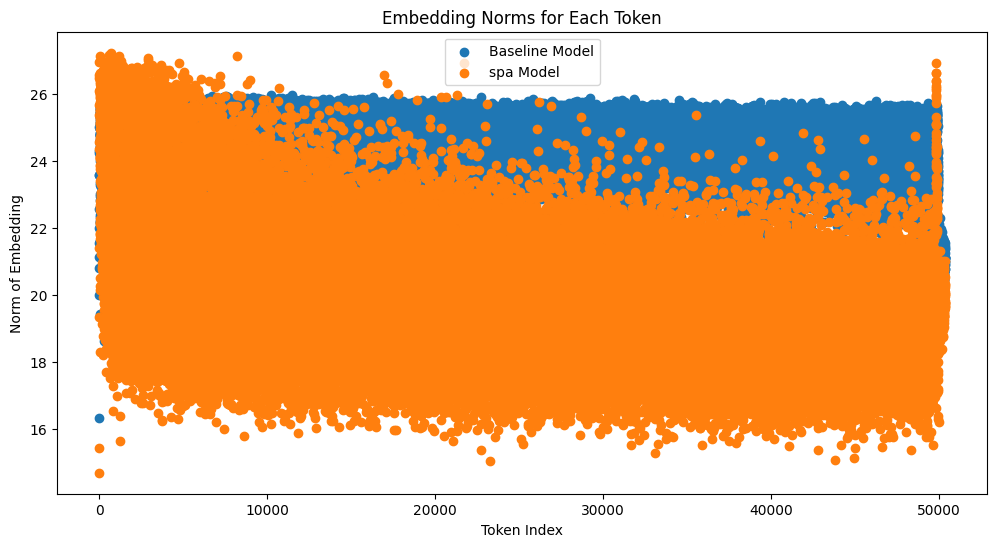

In [28]:

baseline_norms = get_embedding_norms(model_kb)
finetuned_norms = get_embedding_norms(model_hugging_face)
exbert_norms = get_embedding_norms(model_exbert)
#spa_norms =get_embedding_norms(mosaicBert).tolist()
tokens = tokenizer.convert_ids_to_tokens(range(len(baseline_norms.tolist())))
tokens_exbert = exbert_tokenizer.convert_ids_to_tokens(range(len(exbert_norms.tolist())))
#tokens_spa = swerick_tokenizer.convert_ids_to_tokens(range(len(spa_norms)))
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(baseline_norms.tolist())),baseline_norms.tolist(),label='Baseline Model')
plt.scatter(np.arange(len(finetuned_norms.tolist())),finetuned_norms.tolist(), label='spa Model')
plt.xlabel('Token Index')
plt.ylabel('Norm of Embedding')
plt.title('Embedding Norms for Each Token')
plt.legend()
plt.show()


t-statistic: 546.5517389640005
p-value: 0.0


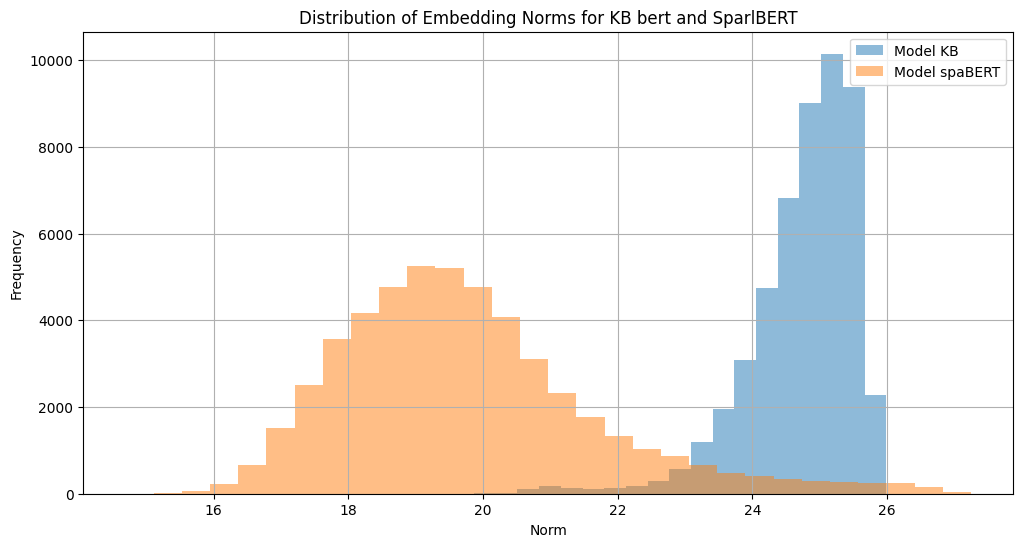

In [31]:
#T statictis comparaison of norms

t_stat, p_value = ttest_ind(baseline_norms.tolist(), finetuned_norms.tolist())

# Print the t-statistic and p-value
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.hist(baseline_norms.tolist(), bins=30, alpha=0.5, label='Model KB')
plt.hist(finetuned_norms.tolist(), bins=30, alpha=0.5, label='Model spaBERT')
plt.title('Distribution of Embedding Norms for KB bert and SparlBERT')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [32]:
embedding_changes = baseline_norms  - finetuned_norms
values,topk=torch.topk(finetuned_norms,100)

token_norm=[tokenizer.convert_ids_to_tokens(token.item()) for token in topk]
token_changes = list(zip(tokens, embedding_changes))
sorted_token_changes = sorted(token_changes, key=lambda x: x[1])
sorted_token=[token for token,change in sorted_token_changes]
positive_norm = [token for token,change in sorted_token_changes if change >0]
negative_norm = [token for token,change in sorted_token_changes if change <0]
print(negative_norm[:100])
print(positive_norm[-100 :])
print(token_norm)

['17', '[SEP]', '10', '##n', '18', '3', '##et', '-', '15', '##er', "'", '##i', '5', '9', '##an', '1', '2', '##d', '##ar', 'Sverige', '##o', '##e', 'kommer', '##at', '##en', 'm', '##na', 'Stockholm', '##r', '8', ')', 's', '##erna', '"', '##ade', '##ning', '##t', 'barn', '»', '##l', 'sedan', 'går', 'över', '23', '##ande', 'själv', 'han', '50', ';', 'A', '>', '14', 'upp', 'se', 'åt', 'gå', '##es', '##m', '##a', 'bara', '##de', 'utskottet', 'fem', 'utan', 'gäller', 'nya', '11', '4', 'finns', 'ta', 'ut', 'vill', '##f', 'fall', '|', '7', 'gör', 'sett', 'in', '30', '22', 'sig', 'bli', 'efter', 'vad', 'ord', 'alltså', 'direkt', 'landet', 'tre', 'komma', 'inte', 'står', '##ens', 'hem', '21', 'år', '##or', 't', '!']
['Insats', 'Casper', 'Värst', 'Läget', 'Jonson', 'Martina', 'Noter', 'Litteratur', 'Bensin', 'Förvänt', 'Wein', 'Programmet', 'Resultaten', 'Problemen', 'Enkelt', 'Börja', 'Räkna', '##check', 'Fritid', 'Digital', 'Idé', 'Bristen', 'Effekten', 'Tolk', 'Torg', 'Innehållet', 'Värdet', '

In [45]:
sorted_token_norms_cpt = sorted(zip(tokens,token_norm), key=lambda x: x[1])
sorted_token_cpt=[token for token, norm in sorted_token_norms_cpt]
print(sorted_token_cpt[-100:])
print(sorted_token_cpt[:100])

sorted_token_norms_kb = sorted(zip(tokens,baseline_norms), key=lambda x: x[1])
sorted_token_kb=[token for token, norm in sorted_token_norms_kb]
print(sorted_token_kb[-100:])


['##ll', '##id', '2', 'h', '##ol', '##der', 'i', 'g', 'D', '##ra', '[SEP]', '"', '##or', 'en', '##el', '##pp', '##ill', 's', '##ri', '##ar', '##de', '##än', '##ch', 'l', '##it', 'a', '##sk', 'H', 'att', 'till', 'v', 'st', '##un', 'b', '##ig', '##lig', '##ning', '.', '##an', '##tt', 'den', '##te', '##in', 'd', 'S', '##en', '##ör', '##ing', 't', 'M', '[CLS]', '##na', '[PAD]', 'det', 'för', 'u', 'k', 'som', '##ck', 'in', '##ed', '##ss', ',', 'sk', '##ro', 'på', '##il', '##om', '##ade', '##at', '##on', '##kt', '##and', '##al', '##är', '##er', 'n', 'och', '1', '[MASK]', '##år', 'är', '##re', 'med', '##am', '##st', '##ter', 'p', 'o', '##att', 'm', '##ag', 'f', '##ån', 'var', 'av', '##et', '-', '[UNK]', 'e']
['##ll', '##id', '2', 'h', '##ol', '##der', 'i', 'g', 'D', '##ra', '[SEP]', '"', '##or', 'en', '##el', '##pp', '##ill', 's', '##ri', '##ar', '##de', '##än', '##ch', 'l', '##it', 'a', '##sk', 'H', 'att', 'till', 'v', 'st', '##un', 'b', '##ig', '##lig', '##ning', '.', '##an', '##tt', 'den',

Correlation between token frequencies and embedding norms: 0.44998257485313453
P-value: 0.0


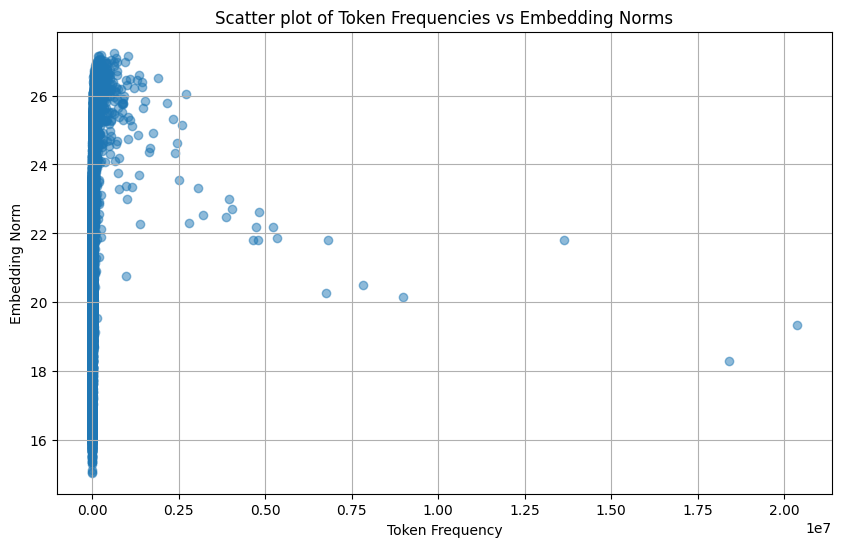

In [44]:
#correlation Frequence - Norm

frequencies = token_frequency_dict.values()
norms = [finetuned_norms[tokenizer.convert_tokens_to_ids(token)].detach().cpu().numpy() for token in list(token_frequency_dict.keys())]
correlation, p_value = spearmanr(list(frequencies), norms)

print(f'Correlation between token frequencies and embedding norms: {correlation}')
print(f'P-value: {p_value}')

# Tracer un graphique de dispersion
plt.figure(figsize=(10, 6))
plt.scatter(frequencies, norms, alpha=0.5)
plt.title('Scatter plot of Token Frequencies vs Embedding Norms')
plt.xlabel('Token Frequency')
plt.ylabel('Embedding Norm')
plt.grid(True)
plt.show()

Study correlation between Cosine similarity - fréquence

In [58]:


ref_weight =get_embedding_normalized(model_hugging_face)
bias_weight = get_embedding_normalized(model_kb)
eb_weight = get_embedding_normalized(model_exbert)

similarities_cpt=[]
similarities_eb=[]
for token in tokenizer.vocab.keys():
    similarities_cpt.append(cosine_similarity(ref_weight[tokenizer.convert_tokens_to_ids(token)],bias_weight[tokenizer.convert_tokens_to_ids(token)]))
    similarities_eb.append(cosine_similarity(eb_weight[exbert_tokenizer.convert_tokens_to_ids(token)],ref_weight[tokenizer.convert_tokens_to_ids(token)]))

token_similarity_cpt = sorted(zip(tokenizer.vocab.keys(), similarities_cpt), key=lambda x: x[1], reverse=True)
token_similarity_eb = sorted(zip(tokenizer.vocab.keys(), similarities_eb), key=lambda x: x[1], reverse=True)
    
classified_words_cpt = [token_id for token_id, similarity in token_similarity_cpt]
similarities_cpt = [sim for token,sim in token_similarity_cpt]
classified_words_eb = [token_id for token_id, similarity in token_similarity_eb]
similarities_eb = [sim for token,sim in token_similarity_eb]
def print_statistics(data, label):
    print(f"Statistics for {label}:")
    print(f"  Mean: {np.mean(data)}")
    print(f"  Median: {np.median(data)}")
    print(f"  Mode: {max(set(data), key=data.count)}")
    print(f"  Standard Deviation: {np.std(data)}")
    print(f"  Min: {np.min(data)}")
    print(f"  Max: {np.max(data)}")
    print()

print_statistics(similarities_cpt, "Cosine Similarity")

Statistics for Cosine Similarity:
  Mean: 0.46181748361757485
  Median: 0.4514070153236389
  Mode: 0.4483552575111389
  Standard Deviation: 0.10380872908244193
  Min: 0.08756478130817413
  Max: 0.8838160634040833



In [60]:
#Token with high or low cosine similairty 

#Low similarity 
print(classified_words_cpt[:200])
#High similarity 
print(classified_words_cpt[-200:])


['än', 'få', 'så', 'vid', 'sig', 'under', 'vad', 'jag', 'skulle', 'något', 'mig', 'ett', 'efter', 'som', 'utan', 'kunna', 'genom', 'annat', 'oss', 'ut', 'inom', 'vara', 'kan', 'dem', 'fram', 'väl', 'om', 'göra', 'ha', 'in', 'eller', 'upp', 'vi', 'får', 'från', 'rätt', 'heller', 'inte', 'då', 'sina', 'att', 'alla', 'någon', 'mot', 'fråga', 'gå', 'hela', 'skall', 'måste', 'för', 'de', 'bara', 'sitt', 'sin', 'komma', 'har', 'åt', 'samma', 'både', 'man', 'över', 'år', 'sedan', 'till', 'gör', 'gång', 'han', 'var', 'allt', 'nu', 'där', 'det', 'långt', 'här', 'står', 'några', 'endast', 'mer', 'sätt', 'nog', 'en', 'går', 'hur', 'tid', 'när', 'kommer', 'vill', 'mellan', 'bör', 'säga', 'på', 'fall', 'ju', 'del', 'men', 'möjligt', 'med', 'stå', 'större', 'just', 'mycket', 'många', 'gäller', 'blir', 'annan', 'ur', 'detta', 'första', 'honom', 'redan', 'se', 'enligt', 'frågan', 'ta', 'är', 'vidare', 'deras', 'olika', 'av', 'exempel', 'hand', 'arbete', 'borde', 'längre', 'sagt', 'hade', 'ens', 'ännu'

Token Prediction

2


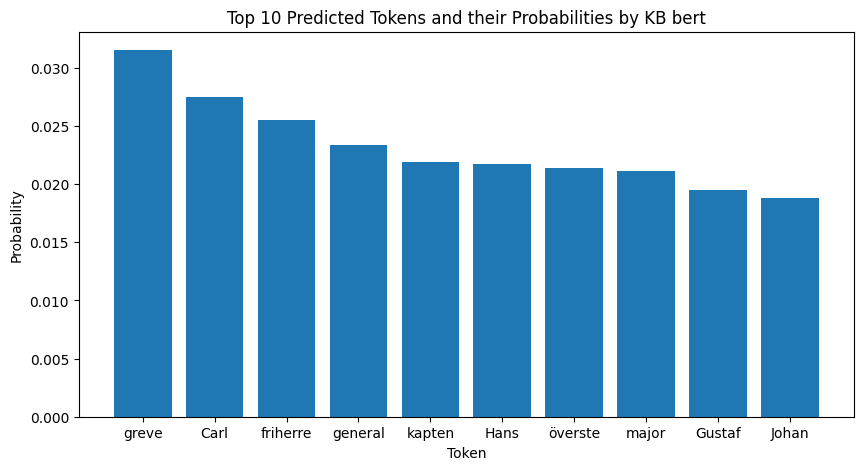

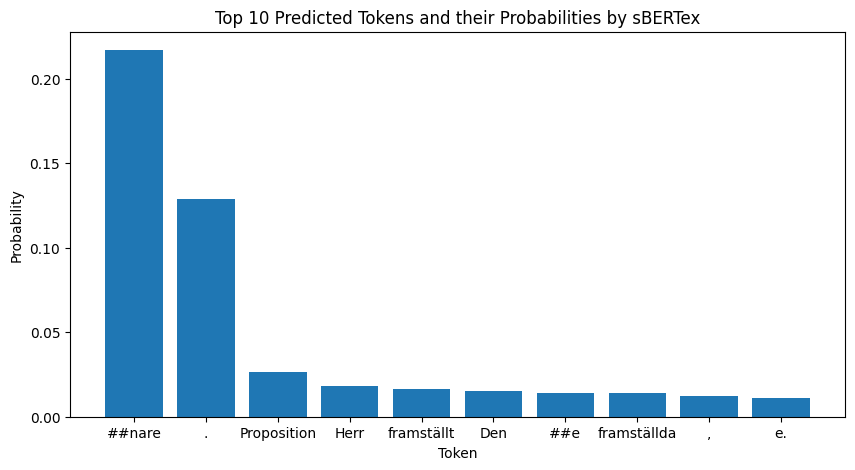

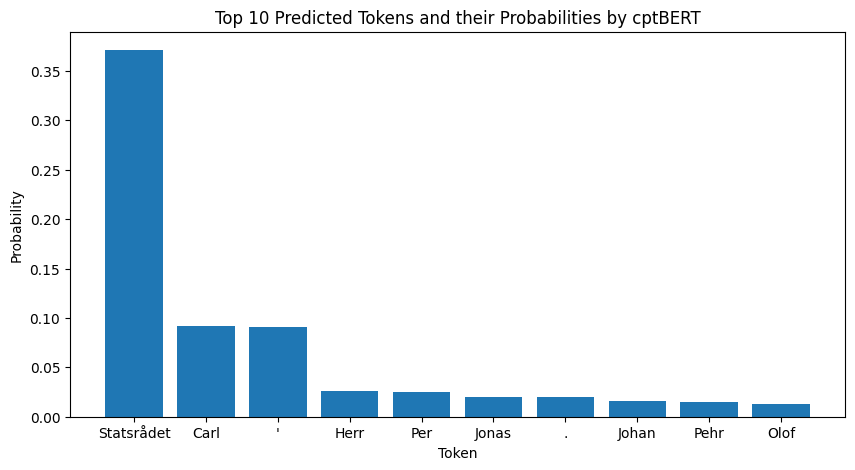

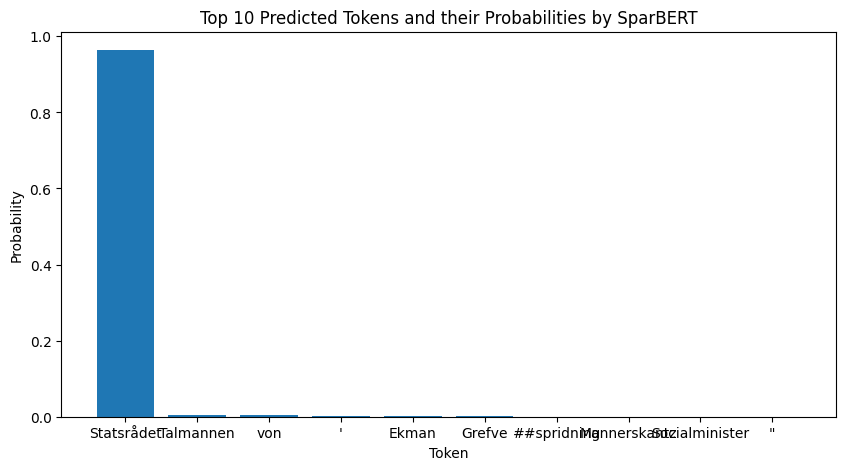

In [74]:

sentence = "Herr [MASK] von Ehrenheim : Anledningen till den framställning"
input_kb=tokenizer(sentence,return_tensors='pt').to(device)
input_eb=exbert_tokenizer(sentence,return_tensors='pt').to(device)
input_mb=swerick_tokenizer(sentence,return_tensors='pt').to(device)

index  =2
print(index)
criterion =nn.CrossEntropyLoss(reduction='none')

with torch.no_grad():
    outputs1 = model_kb(**input_kb,
        output_attentions=True
    )
    outputs2=model_exbert(**input_eb)
    outputs3=model_hugging_face(**input_kb)
    outputs4=mosaicBert(**input_mb)
    
softmax_probs_kb = F.softmax(outputs1.logits.squeeze()[index], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_kb, sorted_probs_kb[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by KB bert')
plt.show()

softmax_probs_eb = F.softmax(outputs2.logits.squeeze()[index], dim=-1)
sorted_probs_eb, sorted_indices_eb = torch.sort(softmax_probs_eb, descending=True)
sorted_tokens_eb = [exbert_tokenizer.decode([idx]) for idx in sorted_indices_eb[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_eb, sorted_probs_eb[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by sBERTex')
plt.show()

softmax_probs_cpt = F.softmax(outputs3.logits.squeeze()[index], dim=-1)
sorted_probs_cpt, sorted_indices_cpt = torch.sort(softmax_probs_cpt, descending=True)
sorted_tokens_cpt = [tokenizer.decode([idx]) for idx in sorted_indices_cpt[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_cpt, sorted_probs_cpt[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by cptBERT')
plt.show()

softmax_probs_sp = F.softmax(outputs4.logits.squeeze()[index], dim=-1)
sorted_probs_sp, sorted_indices_sp = torch.sort(softmax_probs_sp, descending=True)
sorted_tokens_sp = [swerick_tokenizer.decode([idx]) for idx in sorted_indices_sp[:10]]
# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.bar(sorted_tokens_sp, sorted_probs_sp[:10].cpu().numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 10 Predicted Tokens and their Probabilities by SparBERT')
plt.show()